# Matched wavelength photometry

**Version 0.1**

For today's problem, we will be perform matched-aperture photometry in 5 bands on multiple galaxies within a rich galaxy cluster. Ultimately, we will be looking for trends in galaxy colors and other properties as a function of cluster radius.

Note - we will use `astropy` for these tasks, though the use of [`Source Extractor`](https://www.astromatic.net/software/sextractor) is more standard within the galaxy community.


* * *

By M Alpaslan (Columbia) & AA Miller (CIERA/Northwestern & Adler)

## Problem 0) Install photutils

If you have not already done so, install the [`photutils`](http://photutils.readthedocs.io/en/stable/index.html) package from the `astropy` conda channel *within your DSFP environment*. You will also need the [`scikit-image`](http://scikit-image.org) package.

    conda install -c astropy photutils
    conda install scikit-image

In [1]:
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, EllipticalAperture, EllipticalAnnulus
from photutils.segmentation import detect_sources, source_properties
from photutils.detection import detect_threshold
from photutils.centroids import centroid_com
import matplotlib.pyplot as plt

%matplotlib notebook

## Problem 1) Download and Examine the Data

The images for this exercise can be downloaded from here: **URL needed**. Be sure to place the images in the same directory as this notebook (but do not add them to your git repo!).

**Problem 1a**

Display the $r$-band image. Use a logarithmic stretch.

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


<IPython.core.display.Javascript object>


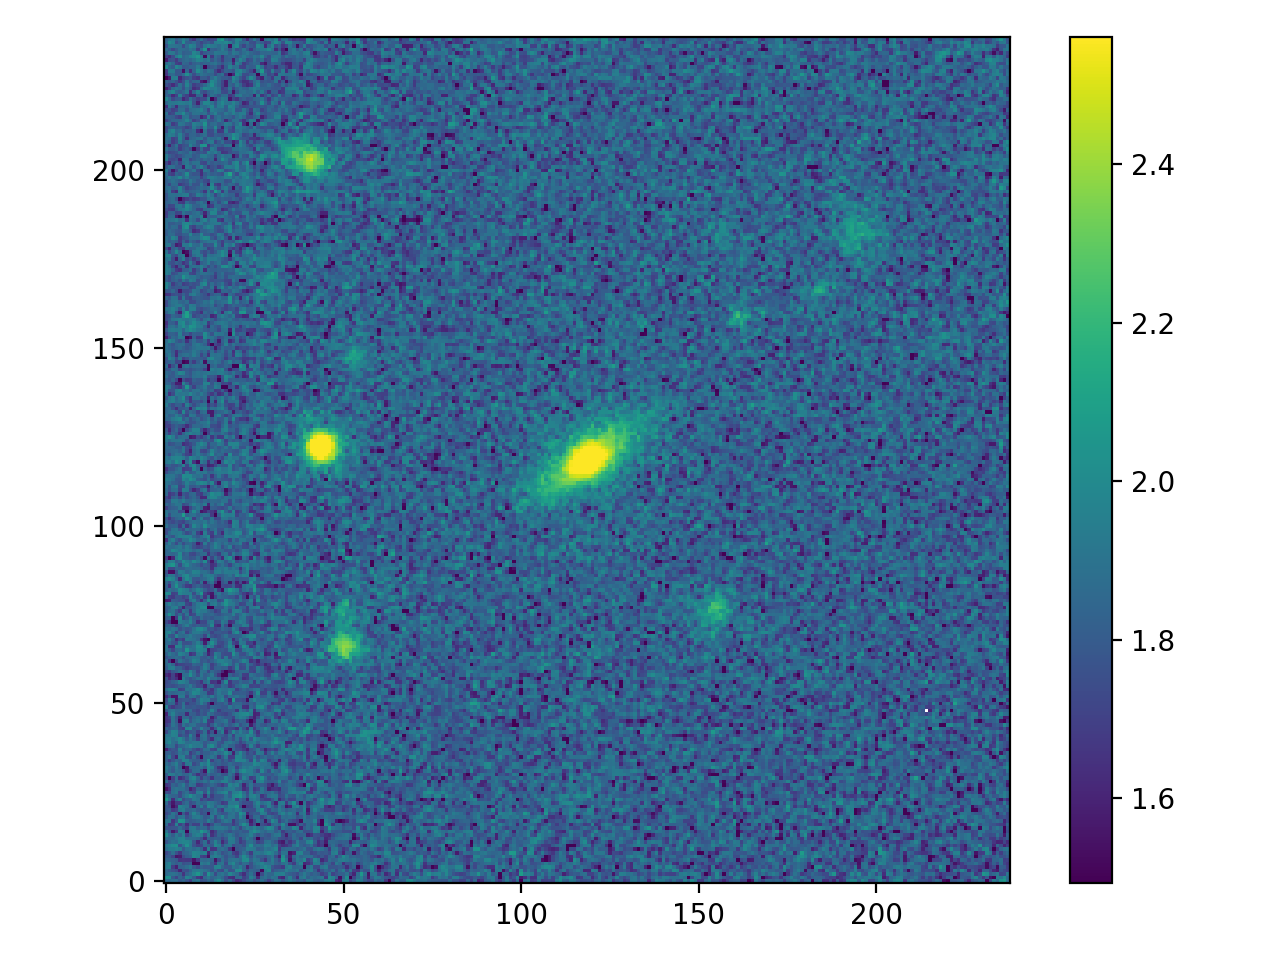

In [14]:
r_filename = "G200018/85698_sdss_r.fits"
r_data = fits.getdata(r_filename)

min_cnts = np.log10(np.percentile(r_data - np.min(r_data), 1))
max_cnts = np.log10(np.percentile(r_data - np.min(r_data), 99.85))

plt.imshow(np.log10(r_data - np.min(r_data)), 
           vmin = min_cnts, vmax = max_cnts,
           cmap='viridis', origin="lower")

plt.colorbar()
plt.tight_layout()

**Problem 1b**

Roughly how many sources are present in the image?

*Hint* - an exact count is not required here.

**Solution 1b**

*Write your answer here*

## Problem 2) Source Detection

Prior to measuring any properties of sources in the image, we must first determine the number of sources present in the image. Source detection is challenging, and there are many different viable approaches. 

Today, we will streamline this step in order to spend more time focusing the issues associated with matching photometric measurements across different images. We will use the [`detect_sources`](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources) function in `photutils` to identify objects in our image.

The simplest model assumes that the background is constant over the entire image. Once the background is determined, it can be subtracted from the image to determine high significance "peaks" corresponding to sources. After this week, we have learned that the background isn't so simple, nevertheless we will use the [`detect_threshold`](http://photutils.readthedocs.io/en/stable/api/photutils.detection.detect_threshold.html#photutils.detection.detect_threshold) convenience function to estimate *a constant* background for our images. `detect_threshold` produces a "detection image" that can be used to estimate the significance of the flux detected in any individual pixel.

**Problem 2a** 

Create a detection threshold image using the `detect_threshold` function.

In [15]:
threshold = detect_threshold(r_data, snr=3.)

**Problem 2b**

Develop better intuition for the detection image by plotting it side-by-side with the actual image of the field.

Do you notice anything interesting about the threshold image?

<IPython.core.display.Javascript object>


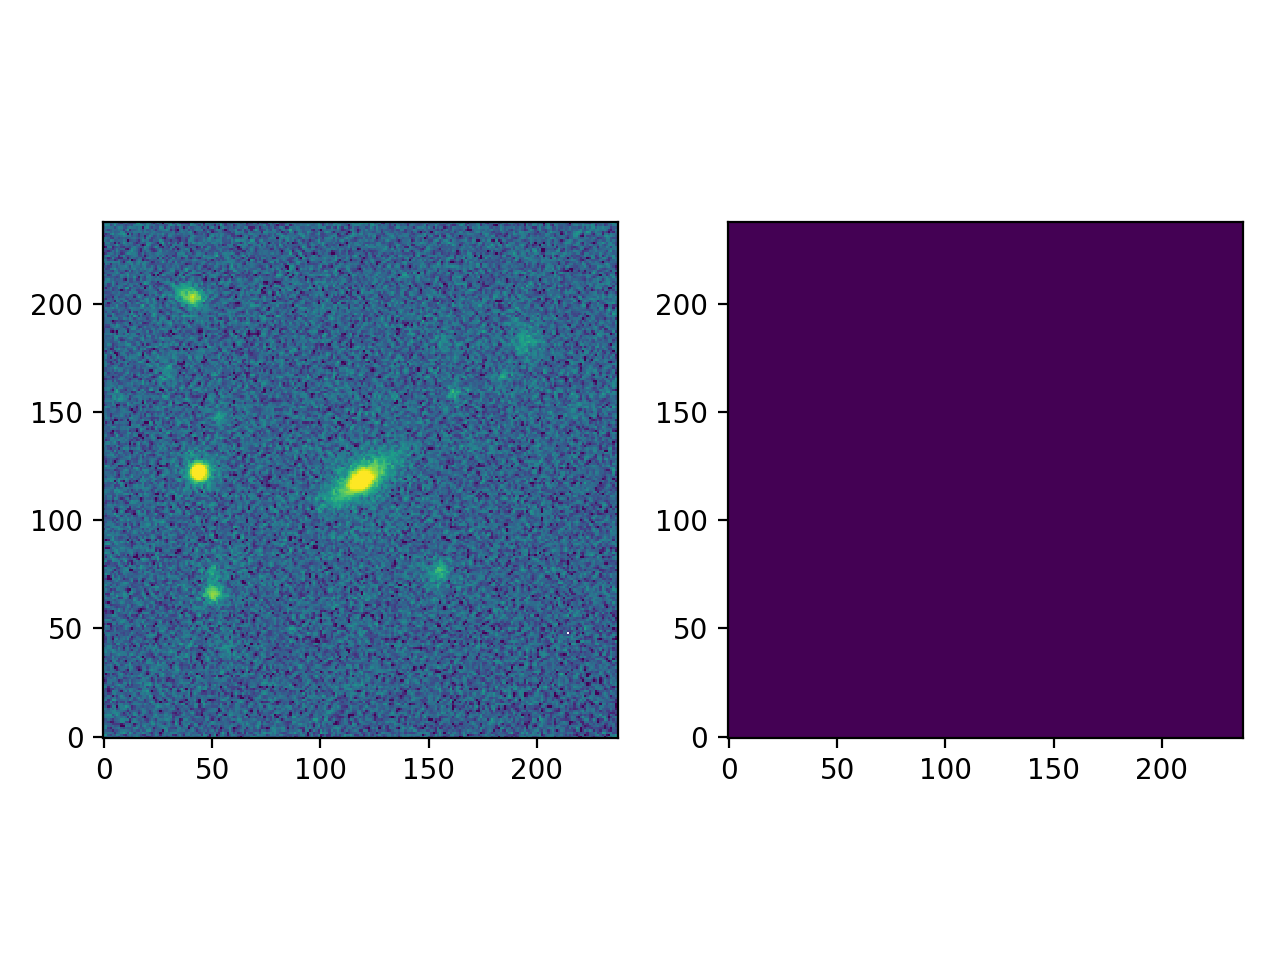

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(np.log10(r_data - np.min(r_data)), 
           vmin = min_cnts, vmax = max_cnts,
           cmap='viridis', origin="lower")
ax2.imshow(np.log10(threshold), 
           cmap='viridis', origin="lower")
fig.tight_layout()

Following this measurement of the background, we can find sources using the `detect_sources` function. Briefly, this function uses image segmentation to define and assign pixels to sources, which are defined as objects with $N$ connected pixels that are $s$ times brighter than the background (we already set $s = 3$). [Read the docs](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources) for further details.

**Problem 2c**

Generate a segmentation image using `detect_sources`. Keep only sources with $N = 7$ pixels, which is keyword arg `npixels` in detect_sources.

*If you have extra time* Come back to this problem and see how changing $N$ affects your results.

In [17]:
segm = detect_sources(r_data, threshold, npixels=7)

**Problem 2d**

Plot the segmentation image side-by-side with the actual image of the field.

Are you concerned or happy with the results?

<IPython.core.display.Javascript object>


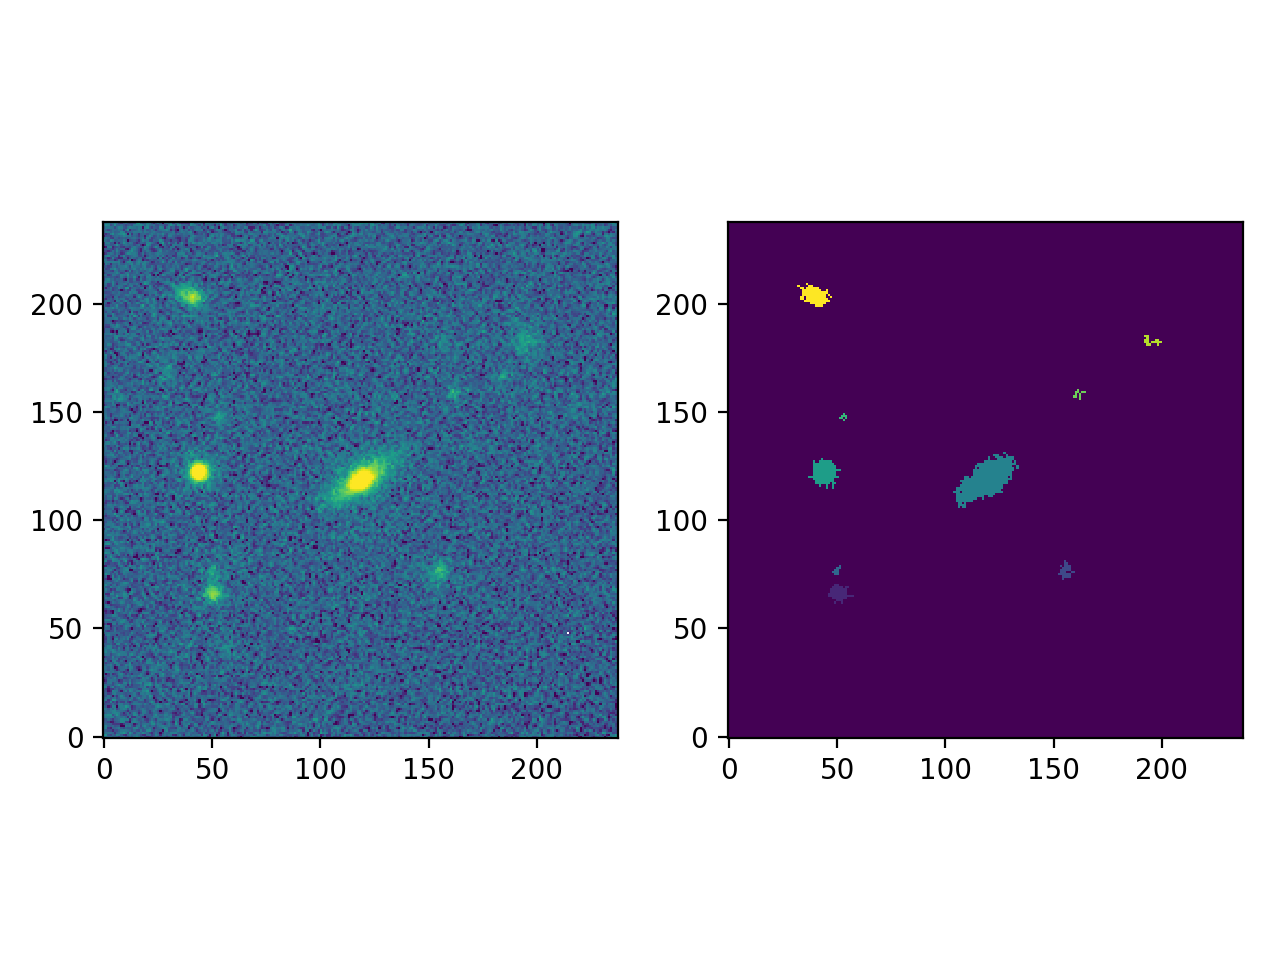

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(np.log10(r_data - np.min(r_data)), 
           vmin = min_cnts, vmax = max_cnts,
           cmap='viridis', origin="lower")
ax2.imshow(segm, 
           origin="lower")
fig.tight_layout()

## Problem 3) Source Centroids

Now that we have defined all of the sources in the image, we must determine the centroid for each source (in order to ultimately make some form of photometric measurement). Like source detection, there are many ways to determine the centroid of a given source (e.g., fitting a model, finding the max of the marginalized 1-d distribution, etc). Today we will use the [`centroid_com`](http://photutils.readthedocs.io/en/stable/api/photutils.centroids.centroid_com.html#photutils.centroids.centroid_com) function, which calculates the "center of mass" of the 2d image moments to determine the source centroids.

To measure the centroid we want to isolate the source in question, thus we have generated a convenience function to return the extent of each source from its corresponding segmentation image.

In [19]:
def get_source_extent(segm_data, source_num):
    """
    Determine extent of sources for centroid measurements
    
    Parameters
    ----------
    segm_data : array-like
        Segementation image produced by photutils.segmentation.detect_sources
    
    source_num : int
        The source number from the segmentation image
        
    Returns
    -------
    source_extent : list
        The minimum y, maximum y, minimum x, and maximum x pixel values 
        over which a source is detected
    """
    source_pix = np.where(segm_data == source_num)
    source_extent = [np.min(source_pix[0]), np.max(source_pix[0]), 
                     np.min(source_pix[1]), np.max(source_pix[1])]

    return source_extent

**Problem 3a** 

Measure the centroid for each source detected in the image using the `centroid_com` function.

*Hint* - you'll want to start with a subset of pixels containing the source.

*Hint 2* - centroids are measured relative to the provided data, you'll need to convert back to "global" pixel values. 

In [47]:
xcentroid = np.zeros_like(np.unique(segm.data)[1:], dtype="float")
ycentroid = np.zeros_like(np.unique(segm.data)[1:], dtype="float")

for source_num in np.unique(segm.data)[1:]:
    source_extent = get_source_extent(segm.data, source_num)
    xc, yc = centroid_com(r_data[source_extent[0]:source_extent[1],
                                 source_extent[2]:source_extent[3]])
    xcentroid[source_num-1], ycentroid[source_num-1] = xc + source_extent[2], yc + source_extent[0]

**Problem 3b**

Overplot the derived centroids on the image data as a sanity check for your methodology.

<IPython.core.display.Javascript object>


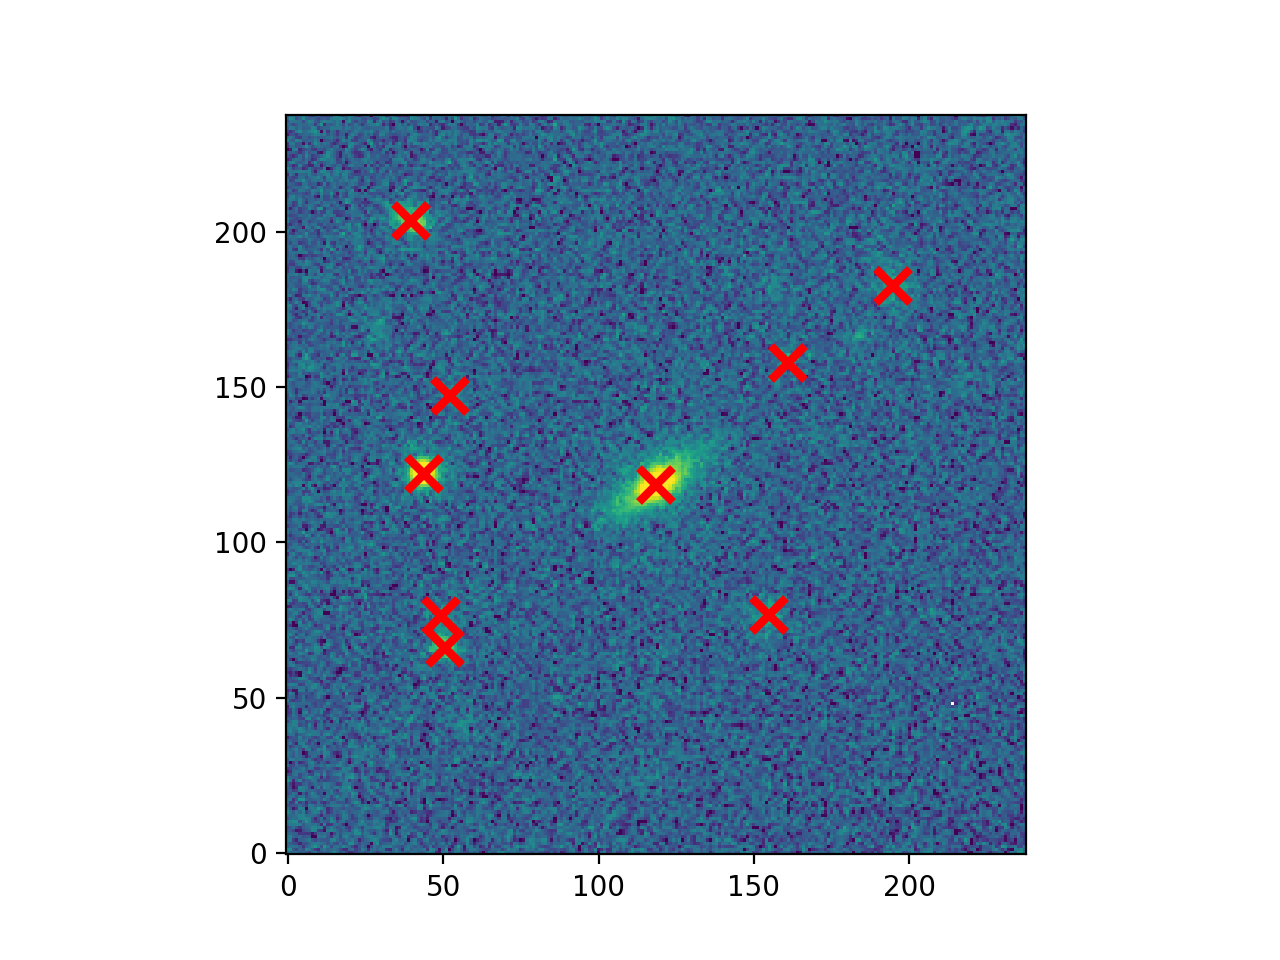

/Users/adamamiller/miniconda3/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
fig, ax1 = plt.subplots()

ax1.imshow(np.log10(r_data - np.min(r_data)), 
           vmin = min_cnts, vmax = max_cnts,
           cmap='viridis', origin="lower")
ax1.plot(xcentroid, ycentroid, 'x', color="red", ms=12, mew=3)